In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def format_sigfig(x, sig=3):
    """Format a number to N significant figures safely."""
    if pd.isna(x):
        return ""
    if x == 0:
        return "0"
    try:
        digits = sig - int(np.floor(np.log10(abs(x)))) - 1
        digits = max(digits, 0)  # Avoid negative precision
        return f"{x:.{digits}f}"
    except Exception:
        return str(x)


def format_mean_std_sigfig(df, sigfig=3, drop_original=True):
    """
    Combine *_mean and *_std columns into a 'mean ± std' column with significant figures.
    """
    df = df.copy()
    new_cols = {}

    for col in df.columns:
        if col.endswith('_mean'):
            base = col[:-5]  # Remove '_mean'
            std_col = f"{base}_std"
            if std_col in df.columns:
                new_col = df.apply(
                    lambda row: f"{format_sigfig(row[col], sigfig)} $\pm$ {format_sigfig(row[std_col], sigfig)}",
                    axis=1
                )
                new_cols[base] = new_col

    for base, formatted_col in new_cols.items():
        df[base] = formatted_col
        if drop_original:
            df.drop(columns=[f"{base}_mean", f"{base}_std"], inplace=True)

    return df

def transpose_clean_for_latex(df, escape=False, index_name="Metric", float_format=None, **latex_kwargs):
    df_t = df.transpose()
    df_t.columns = df_t.iloc[0]
    df_t = df_t[1:]
    df_t = df_t.reset_index().rename(columns={'index': index_name})
    return df_t.to_latex(index=False, escape=escape, float_format=float_format, **latex_kwargs)


### pfb_results

In [2]:
df = pd.read_csv('pfb_results2.csv', sep=',')

# Turn filename into short model name with regex
df[['model', 'batch']] = df['loadable'].str.extract(r'pfb_model_([^-]+)-[^-]+-t\d+-b(\d+)\.nvdla')
df['model_short'] = 'pfb-'+df['model'] + '-b' + df['batch']

# Calculate throughput
df['throughput'] = df['samples'] / df['device_time'] * 1000  # samples per second

# Calculate data rate
# 16 values in per sample, 1 value out per sample, 2 bytes per value
df['bandwidth'] = df['throughput'] * (16 + 1) * 2 / 1e6  # in MB/s

# Calculate samples per joule
df['samples_per_joule'] = df['samples'] / df['energy']

df_stats = df.groupby(['model_short', 'batch']).agg(['mean', 'std'])
# Flatten 
df_stats.columns = ['_'.join(col) for col in df_stats.columns]
df_stats = df_stats.reset_index()

# Sort by model_short
df_stats['batch'] = df_stats['batch'].astype(int)
df_stats = df_stats.sort_values(by=['batch', 'model_short'])

# Split between dft and fft
dft_stats = df_stats[df_stats['model_short'].str.contains('dft')]
fft_stats = df_stats[df_stats['model_short'].str.contains('fft')]

/tmp/ipykernel_138444/875268696.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(dft_stats['model_short'], rotation=45, ha='right')
/tmp/ipykernel_138444/875268696.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(fft_stats['model_short'], rotation=45, ha='right')


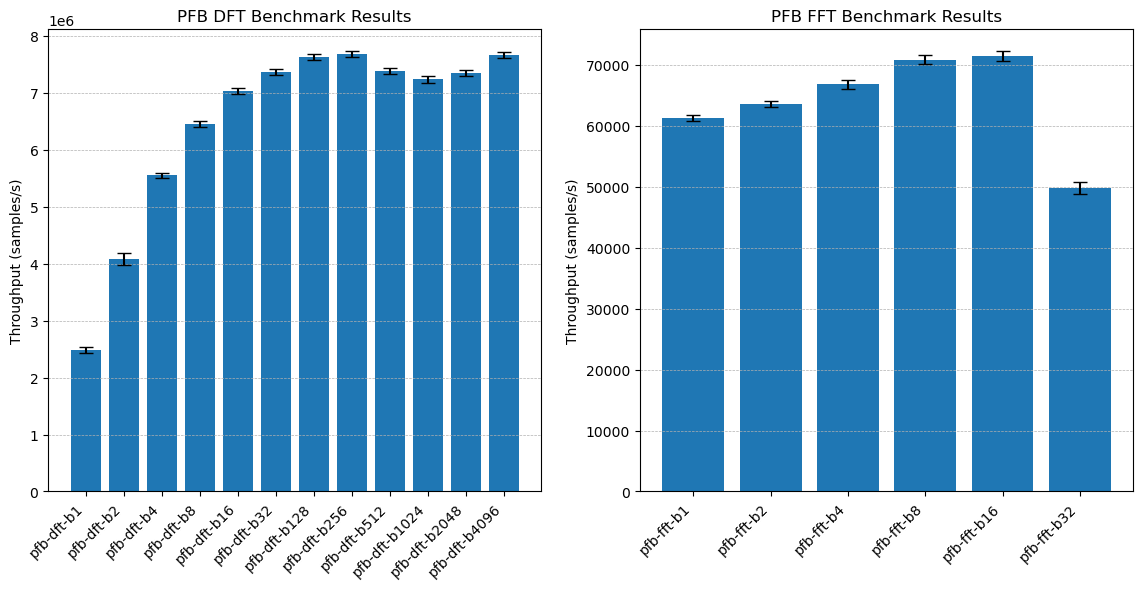

In [3]:
# Plotting of dft and fft in two different subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# Plot DFT stats
axs[0].bar(dft_stats['model_short'], dft_stats['throughput_mean'], yerr=dft_stats['throughput_std'], capsize=5)
axs[0].set_title('PFB DFT Benchmark Results')
axs[0].set_ylabel('Throughput (samples/s)')
axs[0].set_xticklabels(dft_stats['model_short'], rotation=45, ha='right')
axs[0].grid(axis='y', linestyle='--', linewidth=0.5)

# Plot FFT stats
axs[1].bar(fft_stats['model_short'], fft_stats['throughput_mean'], yerr=fft_stats['throughput_std'], capsize=5)
axs[1].set_title('PFB FFT Benchmark Results')
axs[1].set_ylabel('Throughput (samples/s)')
axs[1].set_xticklabels(fft_stats['model_short'], rotation=45, ha='right')
axs[1].grid(axis='y', linestyle='--', linewidth=0.5)

/tmp/ipykernel_138444/1110757937.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(dft_stats['model_short'], rotation=45, ha='right')
/tmp/ipykernel_138444/1110757937.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(fft_stats['model_short'], rotation=45, ha='right')


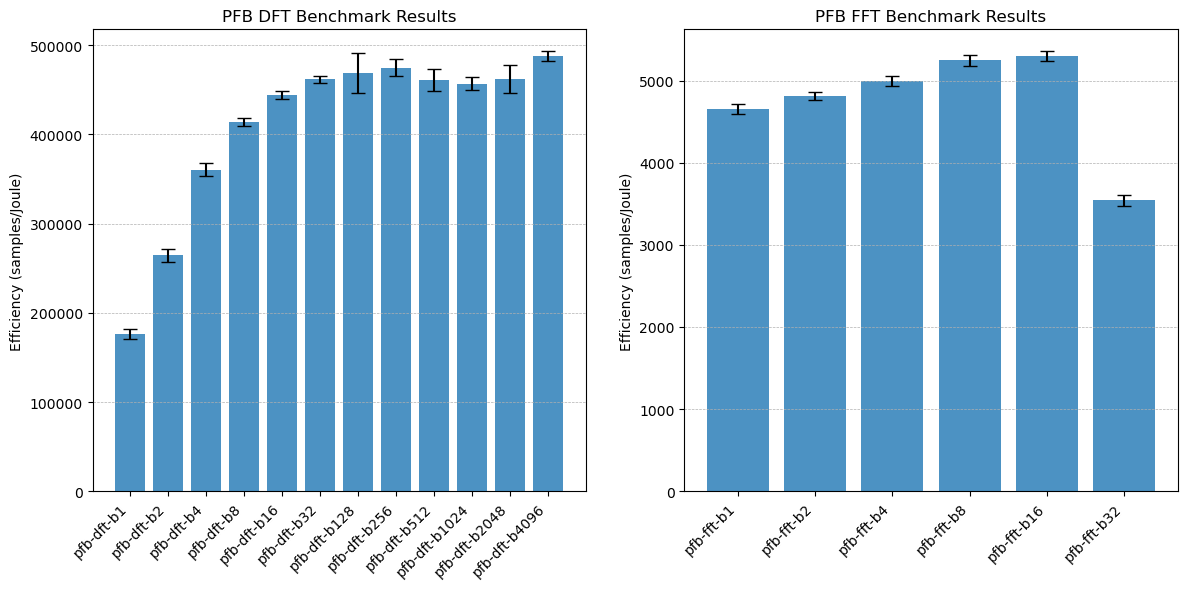

In [4]:
##### Efficiency

# Plotting of dft and fft in two different subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# Plot DFT stats
axs[0].bar(dft_stats['model_short'], dft_stats['samples_per_joule_mean'], yerr=dft_stats['samples_per_joule_std'], capsize=5, alpha=0.8)
axs[0].set_title('PFB DFT Benchmark Results')
axs[0].set_ylabel('Efficiency (samples/Joule)')
axs[0].set_xticklabels(dft_stats['model_short'], rotation=45, ha='right')
axs[0].grid(axis='y', linestyle='--', linewidth=0.5)

# Plot FFT stats
axs[1].bar(fft_stats['model_short'], fft_stats['samples_per_joule_mean'], yerr=fft_stats['samples_per_joule_std'], capsize=5, alpha=0.8)
axs[1].set_title('PFB FFT Benchmark Results')
axs[1].set_ylabel('Efficiency (samples/Joule)')
axs[1].set_xticklabels(fft_stats['model_short'], rotation=45, ha='right')
axs[1].grid(axis='y', linestyle='--', linewidth=0.5)

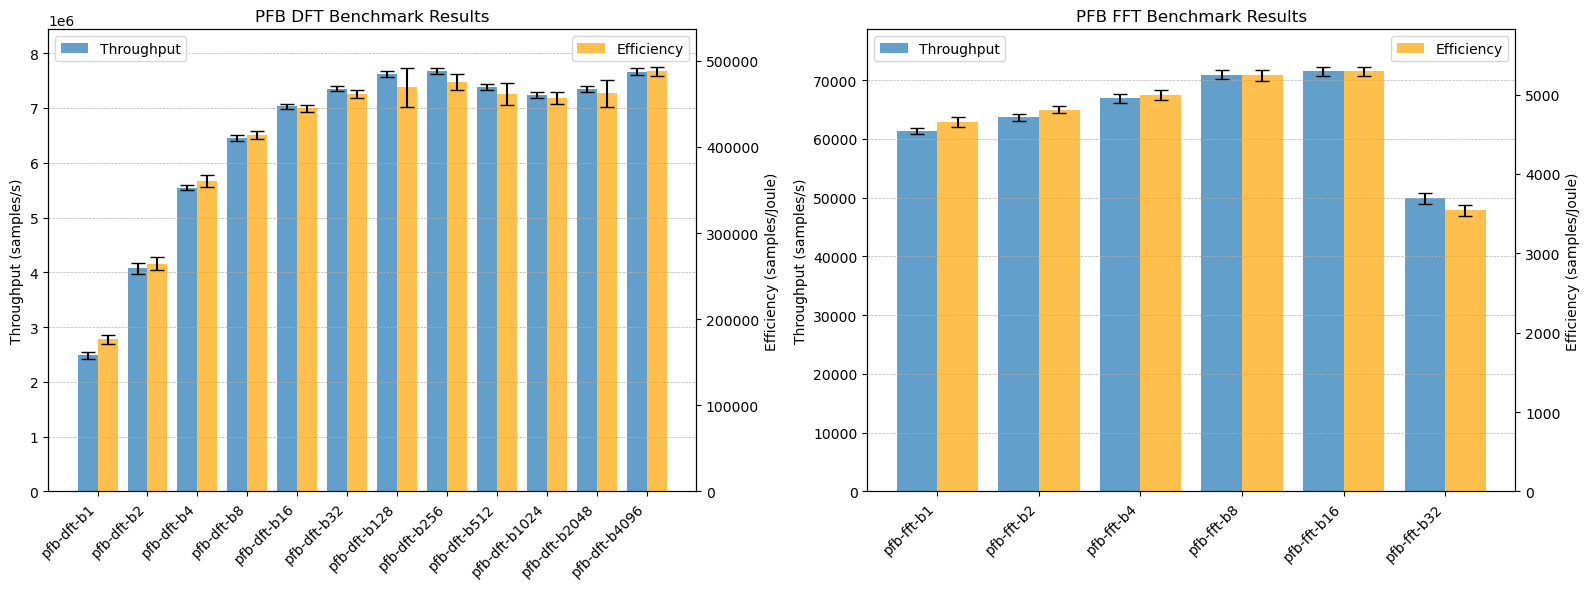

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

x_dft = np.arange(len(dft_stats['model_short']))
x_fft = np.arange(len(fft_stats['model_short']))
width = 0.4

# DFT
ax_d_t = axs[0]
ax_d_e = ax_d_t.twinx()

bar1 = ax_d_t.bar(x_dft - width/2, dft_stats['throughput_mean'], width=width,
               yerr=dft_stats['throughput_std'], capsize=5, label='Throughput', alpha=0.7)
bar2 = ax_d_e.bar(x_dft + width/2, dft_stats['samples_per_joule_mean'], width=width,
               yerr=dft_stats['samples_per_joule_std'], capsize=5, label='Efficiency', alpha=0.7,  color='orange')

ax_d_t.set_title('PFB DFT Benchmark Results')
ax_d_t.set_ylabel('Throughput (samples/s)')
ax_d_e.set_ylabel('Efficiency (samples/Joule)')
ax_d_t.set_xticks(x_dft)
ax_d_t.set_xticklabels(dft_stats['model_short'], rotation=45, ha='right')
ax_d_t.grid(axis='y', linestyle='--', linewidth=0.5)

# FFT
ax_f_t = axs[1]
ax_f_e = ax_f_t.twinx()

bar3 = ax_f_t.bar(x_fft - width/2, fft_stats['throughput_mean'], width=width,
               yerr=fft_stats['throughput_std'], capsize=5, label='Throughput', alpha=0.7)
bar4 = ax_f_e.bar(x_fft + width/2, fft_stats['samples_per_joule_mean'], width=width,
               yerr=fft_stats['samples_per_joule_std'], capsize=5, label='Efficiency', alpha=0.7, color='orange')

ax_f_t.set_title('PFB FFT Benchmark Results')
ax_f_t.set_ylabel('Throughput (samples/s)')
ax_f_e.set_ylabel('Efficiency (samples/Joule)')
ax_f_t.set_xticks(x_fft)
ax_f_t.set_xticklabels(fft_stats['model_short'], rotation=45, ha='right')
ax_f_t.grid(axis='y', linestyle='--', linewidth=0.5)

# Pad y-axis limits
ax_d_t.set_ylim(0, max(dft_stats['throughput_mean']) * 1.1)
ax_f_t.set_ylim(0, max(fft_stats['throughput_mean']) * 1.1)
ax_d_e.set_ylim(0, max(dft_stats['samples_per_joule_mean']) * 1.1)
ax_f_e.set_ylim(0, max(fft_stats['samples_per_joule_mean']) * 1.1)

# Plot legends
ax_d_t.legend(loc='upper left')
ax_f_t.legend(loc='upper left')
ax_d_e.legend(loc='upper right')
ax_f_e.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [6]:
# Export latex table

# Select and copy the stats DataFrame to a new DataFrame for latex export
export_stats = df_stats.copy()
# Sort by model and batch
# export_stats = export_stats.sort_values(by=['batch', 'model'])
export_stats = export_stats[[
        'model_short',
        # 'buffers_mean', 'runs_mean',
        'samples_mean',
       'energy_mean', 'energy_std', 
      #  'host_time_mean', 'host_time_std',
       'device_time_mean', 'device_time_std',
      #  'throughput_mean', 'throughput_std', 
       'bandwidth_mean', 'bandwidth_std',
    #    'samples_per_joule_mean', 'samples_per_joule_std'
       ]].copy()

# Convery Buffers and Runs to int
# export_stats['buffers_mean'] = export_stats['buffers_mean'].astype(int)
# export_stats['runs_mean'] = export_stats['runs_mean'].astype(int)

export_stats['samples_mean'] = export_stats['samples_mean'] / 1e6  # Convert to samples/ms
# export_stats['throughput_mean'] = export_stats['throughput_mean'] / 1e6  # Convert to samples/ms
# export_stats['throughput_std'] = export_stats['throughput_std'] / 1e6  # Convert to samples/ms
formatted_df = format_mean_std_sigfig(export_stats, sigfig=3)
# Sort by model_short
formatted_df['model_short'] = formatted_df['model_short'].astype(str)

# print(formatted_df)
# Rename columns for clarity
formatted_df.rename(columns={
        'model_short': 'Model',
        # 'buffers_mean': 'Buffers',
        # 'runs_mean': 'Runs',
        'samples_mean': 'Msamples',
        'energy': 'Energy (J)',
      #   'host_time': 'Host Time (ms)',
      #   'device_time': 'Device Time (ms)',
        'device_time': 'Time (ms)',
        # 'throughput': 'Throughput (Msamples/s)',
        'bandwidth': 'Bandwidth (MB/s)',
        # 'samples_per_joule': 'Samples/Joule'
    }, inplace=True)
# print(df.to_latex(index=False, escape=False))
# latex_table = transpose_clean_for_latex(formatted_df, escape=False, index_name="Model", float_format=lambda x: f"{x:.3f}")
latex_table = formatted_df.to_latex(index=False, escape=False, float_format=lambda x: f"{x:.3f}")
# print(df_stats.columns)
print(latex_table)

\begin{tabular}{lrlll}
\toprule
        Model &  Msamples &        Energy (J) &       Time (ms) &  Bandwidth (MB/s) \\
\midrule
   pfb-dft-b1 &     2.499 &  14.2 $\pm$ 0.474 & 1006 $\pm$ 22.5 &   84.5 $\pm$ 1.98 \\
   pfb-fft-b1 &     2.499 &    537 $\pm$ 7.50 & 40739 $\pm$ 355 & 2.09 $\pm$ 0.0182 \\
   pfb-dft-b2 &     2.499 &  9.45 $\pm$ 0.275 &  614 $\pm$ 16.6 &    138 $\pm$ 3.54 \\
   pfb-fft-b2 &     2.499 &    519 $\pm$ 5.32 & 39269 $\pm$ 332 & 2.16 $\pm$ 0.0183 \\
   pfb-dft-b4 &     2.499 &  6.93 $\pm$ 0.156 &  451 $\pm$ 3.78 &    189 $\pm$ 1.58 \\
   pfb-fft-b4 &     2.499 &    501 $\pm$ 6.46 & 37372 $\pm$ 430 & 2.27 $\pm$ 0.0262 \\
   pfb-dft-b8 &     2.519 & 6.09 $\pm$ 0.0713 &  390 $\pm$ 2.95 &    219 $\pm$ 1.66 \\
   pfb-fft-b8 &     2.519 &    480 $\pm$ 6.17 & 35550 $\pm$ 379 & 2.41 $\pm$ 0.0257 \\
  pfb-dft-b16 &     2.519 & 5.66 $\pm$ 0.0576 &  358 $\pm$ 2.60 &    239 $\pm$ 1.74 \\
  pfb-fft-b16 &     2.519 &    476 $\pm$ 5.44 & 35248 $\pm$ 375 & 2.43 $\pm$ 0.0259 \\
  

/tmp/ipykernel_138444/1827095407.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dft_b256_stats['dla'], rotation=45, ha='right')


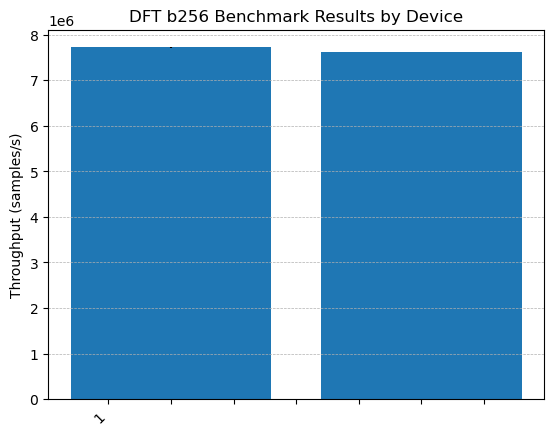

In [7]:
# Plot dft b256 for dla1 and dla2 seperately
dft_b256 = df[df['model_short'].str.contains('dft-b256')]

# Group by device and calculate mean and std
dft_b256_stats = dft_b256.groupby(['dla']).agg(['mean', 'std'])

# FLatten
dft_b256_stats.columns = ['_'.join(col) for col in dft_b256_stats.columns]
dft_b256_stats = dft_b256_stats.reset_index()


# Plot DFT b256 stats
fig, ax = plt.subplots()
ax.bar(dft_b256_stats['dla'], dft_b256_stats['throughput_mean'], yerr=dft_b256_stats['throughput_std'])
ax.set_title('DFT b256 Benchmark Results by Device')
ax.set_ylabel('Throughput (samples/s)')
ax.set_xticklabels(dft_b256_stats['dla'], rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', linewidth=0.5)

### Seperate_results

In [8]:
sep_res = pd.read_csv('seperate_results.csv', sep=',')
sep_res[['model', 'batch']] = sep_res['loadable'].str.extract(r'([a-z]+)_model-c\d+(?:-t\d+)?-b(\d+)\.nvdla')
sep_res['model_short'] = sep_res['model'] + '-b' + sep_res['batch']

# # Calculate throughput
sep_res['throughput'] = sep_res['samples'] / sep_res['device_time'] * 1000  # samples per second

# Calculate data rate
# 1 values in per sample, 1 value out per sample, 2 bytes per value
sep_res['bandwidth'] = np.where(
                                sep_res['model_short'].str.contains('dft'),
                                sep_res['throughput'] * (1 + 1) * 2 / 1e6,
                                sep_res['throughput'] * (16 + 1) * 2 / 1e6
                                )  # in MB/s

# Calculate samples per joule
sep_res['samples_per_joule'] = sep_res['samples'] / sep_res['energy']

sep_stats = sep_res.groupby(['model_short', 'batch']).agg(['mean', 'std'])
# Flatten 
sep_stats.columns = ['_'.join(col) for col in sep_stats.columns]
sep_stats = sep_stats.reset_index()

# Sort by model_short
sep_stats['batch'] = sep_stats['batch'].astype(int)
sep_stats = sep_stats.sort_values(by='batch')

sep_stats_dft = sep_stats[sep_stats['model_short'].str.contains('dft')]
sep_stats_fir = sep_stats[sep_stats['model_short'].str.contains('fir')]

/tmp/ipykernel_138444/3889128311.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(sep_stats_dft['model_short'], rotation=45, ha='right')
/tmp/ipykernel_138444/3889128311.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(sep_stats_fir['model_short'], rotation=45, ha='right')


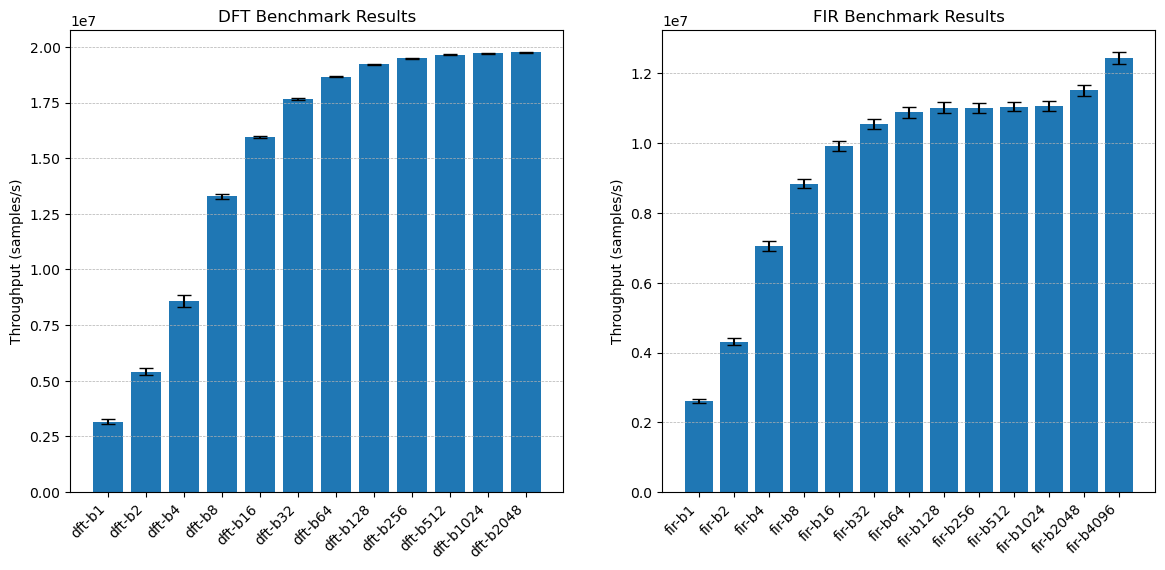

In [9]:
# Plotting of FIR and DFT in two different subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# Plot DFT stats
axs[0].bar(sep_stats_dft['model_short'], sep_stats_dft['throughput_mean'], yerr=sep_stats_dft['throughput_std'], capsize=5)
axs[0].set_title('DFT Benchmark Results')
axs[0].set_ylabel('Throughput (samples/s)')
axs[0].set_xticklabels(sep_stats_dft['model_short'], rotation=45, ha='right')
axs[0].grid(axis='y', linestyle='--', linewidth=0.5)

# Plot FIR stats
axs[1].bar(sep_stats_fir['model_short'], sep_stats_fir['throughput_mean'], yerr=sep_stats_fir['throughput_std'], capsize=5)
axs[1].set_title('FIR Benchmark Results')
axs[1].set_ylabel('Throughput (samples/s)')
axs[1].set_xticklabels(sep_stats_fir['model_short'], rotation=45, ha='right')
axs[1].grid(axis='y', linestyle='--', linewidth=0.5)

/tmp/ipykernel_138444/3582945666.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(sep_stats_dft['model_short'], rotation=45, ha='right')
/tmp/ipykernel_138444/3582945666.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(sep_stats_fir['model_short'], rotation=45, ha='right')


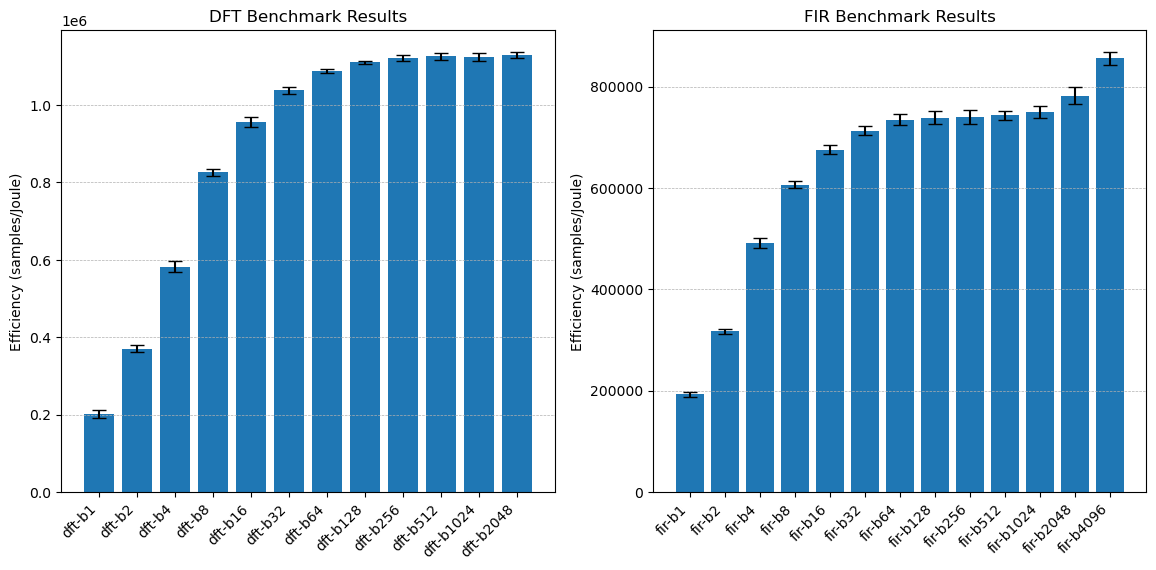

In [10]:
# FIR and DFT efficiency

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# Plot DFT stats
axs[0].bar(sep_stats_dft['model_short'], sep_stats_dft['samples_per_joule_mean'], yerr=sep_stats_dft['samples_per_joule_std'], capsize=5)
axs[0].set_title('DFT Benchmark Results')
axs[0].set_ylabel('Efficiency (samples/Joule)')
axs[0].set_xticklabels(sep_stats_dft['model_short'], rotation=45, ha='right')
axs[0].grid(axis='y', linestyle='--', linewidth=0.5)

# Plot FIR stats
axs[1].bar(sep_stats_fir['model_short'], sep_stats_fir['samples_per_joule_mean'], yerr=sep_stats_fir['samples_per_joule_std'], capsize=5)
axs[1].set_title('FIR Benchmark Results')
axs[1].set_ylabel('Efficiency (samples/Joule)')
axs[1].set_xticklabels(sep_stats_fir['model_short'], rotation=45, ha='right')
axs[1].grid(axis='y', linestyle='--', linewidth=0.5)

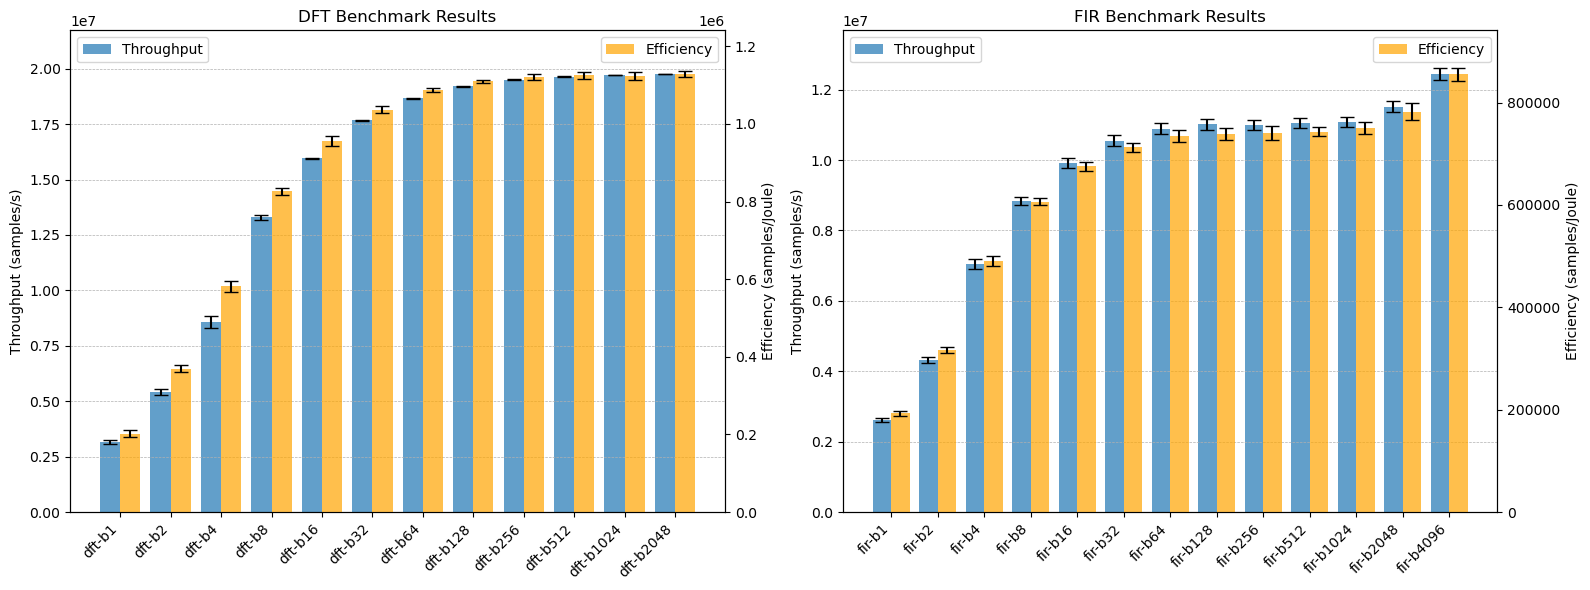

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

x_dft = np.arange(len(sep_stats_dft['model_short']))
x_fir = np.arange(len(sep_stats_fir['model_short']))

width = 0.4

# DFT
ax_d_t = axs[0]
ax_d_e = ax_d_t.twinx()

bar1 = ax_d_t.bar(x_dft - width/2, sep_stats_dft['throughput_mean'], width=width,
               yerr=sep_stats_dft['throughput_std'], capsize=5, label='Throughput', alpha=0.7)
bar2 = ax_d_e.bar(x_dft + width/2, sep_stats_dft['samples_per_joule_mean'], width=width,
               yerr=sep_stats_dft['samples_per_joule_std'], capsize=5, label='Efficiency', alpha=0.7,  color='orange')

ax_d_t.set_title('DFT Benchmark Results')
ax_d_t.set_ylabel('Throughput (samples/s)')
ax_d_e.set_ylabel('Efficiency (samples/Joule)')
ax_d_t.set_xticks(x_dft)
ax_d_t.set_xticklabels(sep_stats_dft['model_short'], rotation=45, ha='right')
ax_d_t.grid(axis='y', linestyle='--', linewidth=0.5)

# FFT
ax_f_t = axs[1]
ax_f_e = ax_f_t.twinx()

bar3 = ax_f_t.bar(x_fir - width/2, sep_stats_fir['throughput_mean'], width=width,
               yerr=sep_stats_fir['throughput_std'], capsize=5, label='Throughput', alpha=0.7)
bar4 = ax_f_e.bar(x_fir + width/2, sep_stats_fir['samples_per_joule_mean'], width=width,
               yerr=sep_stats_fir['samples_per_joule_std'], capsize=5, label='Efficiency', alpha=0.7, color='orange')

ax_f_t.set_title('FIR Benchmark Results')
ax_f_t.set_ylabel('Throughput (samples/s)')
ax_f_e.set_ylabel('Efficiency (samples/Joule)')
ax_f_t.set_xticks(x_fir)
ax_f_t.set_xticklabels(sep_stats_fir['model_short'], rotation=45, ha='right')
ax_f_t.grid(axis='y', linestyle='--', linewidth=0.5)

# Pad y-axis limits
ax_d_t.set_ylim(0, max(sep_stats_dft['throughput_mean']) * 1.1)
ax_f_t.set_ylim(0, max(sep_stats_fir['throughput_mean']) * 1.1)
ax_d_e.set_ylim(0, max(sep_stats_dft['samples_per_joule_mean']) * 1.1)
ax_f_e.set_ylim(0, max(sep_stats_fir['samples_per_joule_mean']) * 1.1)

# Plot legends
ax_d_t.legend(loc='upper left')
ax_f_t.legend(loc='upper left')
ax_d_e.legend(loc='upper right')
ax_f_e.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [16]:
# Export latex table

# Select and copy the stats DataFrame to a new DataFrame for latex export
sep_export_stats = sep_stats.copy()

# Sort by model and batch
# sep_export_stats = sep_export_stats.sort_values(by=['batch', 'model'])
sep_export_stats = sep_export_stats[[
        'model_short',
        # 'buffers_mean', 'runs_mean',
        'samples_mean',
       'energy_mean', 'energy_std', 
      #  'host_time_mean', 'host_time_std',
       'device_time_mean', 'device_time_std',
      #  'throughput_mean', 'throughput_std', 
       'bandwidth_mean', 'bandwidth_std',
    #    'samples_per_joule_mean', 'samples_per_joule_std'
       ]].copy()

# Convery Buffers and Runs to int
# sep_export_stats['buffers_mean'] = sep_export_stats['buffers_mean'].astype(int)
# sep_export_stats['runs_mean'] = sep_export_stats['runs_mean'].astype(int)

sep_export_stats['samples_mean'] = sep_export_stats['samples_mean'] / 1e6  # Convert to samples/ms
# sep_export_stats['throughput_mean'] = sep_export_stats['throughput_mean'] / 1e6  # Convert to samples/ms
# sep_export_stats['throughput_std'] = sep_export_stats['throughput_std'] / 1e6  # Convert to samples/ms
sep_export = format_mean_std_sigfig(sep_export_stats, sigfig=3)
# Sort by model_short
sep_export['model_short'] = sep_export['model_short'].astype(str)

# print(formatted_df)
# Rename columns for clarity
sep_export.rename(columns={
        'model_short': 'Model',
        # 'buffers_mean': 'Buffers',
        # 'runs_mean': 'Runs',
        'samples_mean': 'Msamples',
        'energy': 'Energy (J)',
      #   'host_time': 'Host Time (ms)',
      #   'device_time': 'Device Time (ms)',
        'device_time': 'Time (ms)',
        # 'throughput': 'Throughput (Msamples/s)',
        'bandwidth': 'Bandwidth (MB/s)',
        # 'samples_per_joule': 'Samples/Joule'
    }, inplace=True)
# print(df.to_latex(index=False, escape=False))
# latex_table = transpose_clean_for_latex(sep_export, escape=False, index_name="Model", float_format=lambda x: f"{x:.3f}")
latex_table = sep_export.to_latex(index=False, escape=False, float_format=lambda x: f"{x:.3f}")
# print(df_stats.columns)
print(latex_table)

\begin{tabular}{lrlll}
\toprule
    Model &  Msamples &         Energy (J) &        Time (ms) &  Bandwidth (MB/s) \\
\midrule
   dft-b1 &     2.000 &   9.93 $\pm$ 0.497 &   635 $\pm$ 21.5 &  12.6 $\pm$ 0.431 \\
   fir-b1 &     2.499 &   13.0 $\pm$ 0.297 &   955 $\pm$ 20.8 &   89.0 $\pm$ 1.97 \\
   dft-b2 &     2.000 &   5.41 $\pm$ 0.135 &   370 $\pm$ 10.2 &  21.6 $\pm$ 0.604 \\
   fir-b2 &     2.499 &   7.88 $\pm$ 0.132 &   579 $\pm$ 11.6 &    147 $\pm$ 2.99 \\
   fir-b4 &     2.499 &   5.09 $\pm$ 0.106 &   355 $\pm$ 7.24 &    239 $\pm$ 4.86 \\
   dft-b4 &     1.999 &  3.44 $\pm$ 0.0833 &   233 $\pm$ 7.42 &   34.3 $\pm$ 1.11 \\
   fir-b8 &     2.519 &  4.16 $\pm$ 0.0503 &   285 $\pm$ 4.01 &    301 $\pm$ 4.22 \\
   dft-b8 &     1.999 &  2.42 $\pm$ 0.0272 &   150 $\pm$ 1.29 &  53.2 $\pm$ 0.450 \\
  dft-b16 &     1.999 &  2.09 $\pm$ 0.0284 &  125 $\pm$ 0.341 &  63.8 $\pm$ 0.173 \\
  fir-b16 &     2.519 &  3.73 $\pm$ 0.0472 &   254 $\pm$ 3.65 &    337 $\pm$ 4.84 \\
  fir-b32 &     2.556 & 

### Power dump file

In [12]:
# Power dump file 

df = pd.read_csv('../runtime/benchmark_dump.txt', sep=' ')

# Drop first 200 ms and after 500 ms
# df = df[df['time'] < 0.500 ]
df = df[df['time'] > 0.250 ]

samples = df[df['marker'] == 'S']
markers = df[df['marker'] != 'S']
# smoothen the power values
samples.loc[:, 'power0_smooth'] = samples['power0'].rolling(window=50, center=True).mean()
# print len of samples
print(f"Number of samples: {len(samples)}")



plt.xlabel('Time')
plt.ylabel('Power (W)')

print(df.head())

# Generate unique colors for each marker type
unique_markers = markers['marker'].unique()
colors = cm.get_cmap('tab10', len(unique_markers))  # Use a colormap with enough colors

# Plot vertical lines by marker type
for idx, marker_type in enumerate(unique_markers):
    group = markers[markers['marker'] == marker_type]
    for _, m in group.iterrows():
        plt.axvline(x=m['time'], color=colors(idx), linestyle='--', alpha=0.7, label=marker_type if _ == group.index[0] else "")


plt.plot(samples['time'], samples['power0_smooth'])

plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '../runtime/benchmark_dump.txt'